In [ ]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_squared_error

def crear_modelo():
    modelo = Sequential()
    modelo.add(LSTM(units=50, input_shape=dim_entrada))
    modelo.add(Dense(units=dim_salida))
    modelo.compile(optimizer='rmsprop', loss='mse')
    return modelo

def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)], color='red', label='NO2 Medido')
    plt.plot(prediccion, color='blue', label='NO2 predicho')
    plt.ylim(0, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de NO2')
    plt.legend()
    plt.show()

# Carga y preprocesamiento de datos
dataset = pd.read_excel('rmcab completo.xlsx', sheet_name='pno2', index_col='Date', parse_dates=['Date'])
no2 = 'NO2'
dataset[no2].replace("----", np.nan, inplace=True)
dataset.dropna(subset=[no2], inplace=True)

set_entrenamiento = dataset[:'2022'].iloc[:, 1:2]
set_validacion = dataset['2023':].iloc[:, 1:2]

sc = MinMaxScaler(feature_range=(0, 1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

# Preparación de datos para LSTM
time_step = 60
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step, m):
    X_train.append(set_entrenamiento_escalado[i-time_step:i, 0])
    Y_train.append(set_entrenamiento_escalado[i, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

dim_entrada = (X_train.shape[1], 1)
dim_salida = 1

# Definición del modelo para GridSearchCV
modelo = KerasRegressor(model=crear_modelo, verbose=0)

# Definición de los parámetros para GridSearchCV
parametros = {'epochs': [20, 30, 40]}

# Búsqueda de hiperparámetros
grid = GridSearchCV(estimator=modelo, param_grid=parametros, scoring='neg_mean_squared_error', cv=3)
grid_result = grid.fit(X_train, Y_train)

# Mostrar resultados
print("Mejor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Entrenar el modelo con los mejores hiperparámetros
mejor_modelo = grid.best_estimator_.model

# Entrenamiento del modelo
history = mejor_modelo.fit(X_train, Y_train, epochs=grid.best_params_['epochs'], batch_size=32)

# Preparación y predicción con datos de validación
x_test = set_validacion.values
x_test = sc.transform(x_test)
X_test = []

for i in range(time_step, len(x_test)):
    X_test.append(x_test[i-time_step:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

prediccion = mejor_modelo.predict(X_test)
prediccion = np.maximum(prediccion, 0)  # Limita los valores predichos a un mínimo de 0
prediccion = sc.inverse_transform(prediccion)

# Visualización de las predicciones
graficar_predicciones(set_validacion.values, prediccion)

# Guardar el modelo
mejor_modelo.model.save("modelv2.h5")
print("Modelo guardado.")


ModuleNotFoundError: No module named 'scikeras'

204/204 [==============================] - 1s 3ms/step


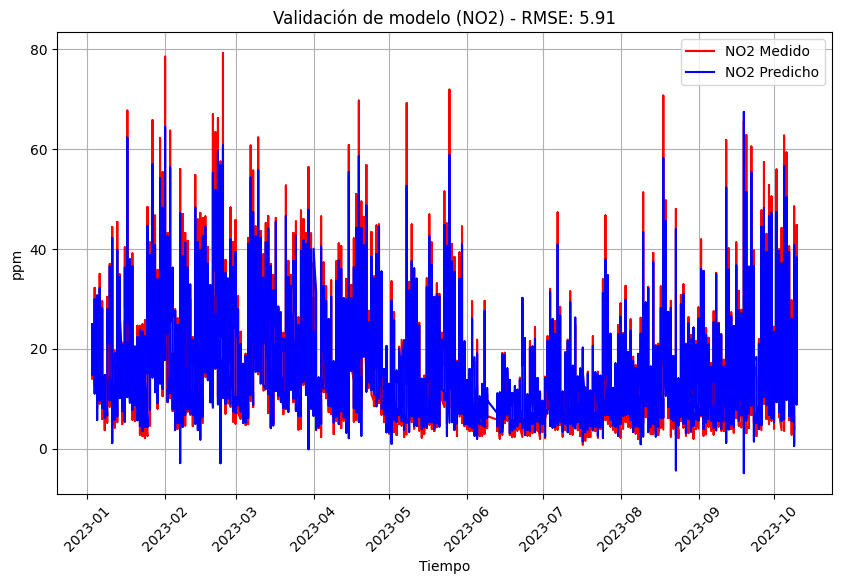

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model

# Cargar los datos de validación
dataset = pd.read_excel('rmcab completo.xlsx', sheet_name='pno2', index_col='Date', parse_dates=['Date'])
no2 = 'NO2'
dataset[no2].replace("----", np.nan, inplace=True)
dataset.dropna(subset=[no2], inplace=True)
set_validacion = dataset['2023':].iloc[:, 1:2]

# Escalar los datos de validación
sc = MinMaxScaler(feature_range=(0,1))
x_test = set_validacion.values
x_test = sc.fit_transform(x_test)

# Preparar los datos de entrada para la predicción
time_step = 60
X_test = []
for i in range(time_step, len(x_test)):
    X_test.append(x_test[i-time_step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Cargar el modelo entrenado
modelo = load_model('modelv2.h5')

# Realizar predicciones
prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

# Calcular el Error Cuadrático Medio (MSE)
mse = np.mean((set_validacion.values[time_step:] - prediccion)**2)
rmse=np.sqrt(mse)
# Calculando el error absoluto porcentual
absolute_percentage_error = np.abs((set_validacion.values[time_step:] - prediccion) / set_validacion.values[time_step:]) * 100

# Calculando el MAPE (Mean Absolute Percentage Error)
mape = np.mean(absolute_percentage_error)

# Obtener fechas para el eje x
fechas = set_validacion.index[time_step:]

# Graficar resultados
plt.figure(figsize=(10, 6))
plt.plot(fechas, set_validacion.values[time_step:], color='red', label='NO2 Medido')
plt.plot(fechas, prediccion, color='blue', label='NO2 Predicho')
plt.xlabel('Tiempo')
plt.ylabel('ppm')  # Etiqueta del eje y
plt.title('Validación de modelo (NO2) - RMSE: {:.2f}'.format(rmse))  # Título del gráfico con MSE
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para una mejor legibilidad
plt.legend()
plt.grid()
plt.show()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                10400     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


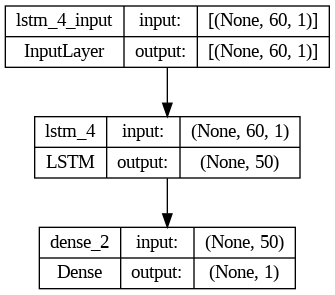

In [ ]:

from keras.utils import plot_model
from keras.models import load_model
import numpy as np


model = load_model('modelv2.h5')
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)